# IMPORT AND LIBRARIES

In [1]:
!pip install torch-geometric 
!pip install nlpaug
import os, re, json, random, warnings
import numpy as np, pandas as pd
import torch, torch.nn as nn, torch.optim as optim, torch.nn.functional as F
import matplotlib.pyplot as plt, seaborn as sns

from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn.utils import resample
from transformers import AutoTokenizer, AutoModel
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
import nlpaug.augmenter.word as naw

warnings.filterwarnings("ignore")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 9.5 MB/s eta 0:00:00


2025-04-15 11:31:56.678110: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744716716.872554      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744716716.929613      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Configuration & Constants

In [2]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

DATA_PATHS = {
    "train": "/kaggle/input/deception/train (1).jsonl",
    "val"  : "/kaggle/input/deception/validation.jsonl",
    "test" : "/kaggle/input/deception/test.jsonl"
}

MAX_EPOCHS = 15
GRID_WEIGHTS = [2.0, 3.0, 4.0]
BETA = 1.5
STEP = 512

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cuda


# Load and Process JSONL Data

In [3]:
def load_jsonl(fp, split_name):
    rows = []
    with open(fp) as f:
        for ln in f:
            g = json.loads(ln)
            for i, msg in enumerate(g["messages"]):
                if g["sender_labels"][i] == "NOANNOTATION":
                    continue
                rows.append(dict(
                    message=msg,
                    processed=re.sub(r"[^\w\s]", "", msg.lower()),
                    power_diff=-int(g["game_score_delta"][i]),
                    is_deceptive=0 if g["sender_labels"][i] else 1,
                    speaker=g["speakers"][i],
                    year=int(g["years"][i]),
                    season=g["seasons"][i],
                    split=split_name
                ))
    return pd.DataFrame(rows)

full = pd.concat([load_jsonl(p, k) for k, p in DATA_PATHS.items()], ignore_index=True)


# Augmentation & OverSampling

In [4]:
train = full[full.split == "train"].copy()
maj, min_ = train[train.is_deceptive == 0], train[train.is_deceptive == 1]

aug = naw.SynonymAug(aug_src="wordnet")
aug_rows = []

for _, r in min_.iterrows():
    try:
        new = aug.augment(r.message)
    except:
        new = r.message
    aug_rows.append({**r, "message": new, "processed": re.sub(r"[^\w\s]", "", new.lower())})

aug_df = pd.DataFrame(aug_rows)
balanced = resample(pd.concat([min_, aug_df]), replace=True,
                    n_samples=len(maj), random_state=SEED)

train_bal = pd.concat([maj, balanced]).sample(frac=1, random_state=SEED)
full_bal = pd.concat([train_bal, full[full.split != "train"]]).reset_index(drop=True)
print("Balanced counts:", train_bal.is_deceptive.value_counts().to_dict())


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package ave

Balanced counts: {1: 12541, 0: 12541}


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package ave

# BERT Embeddings (CLS Token)

In [5]:
tok = AutoTokenizer.from_pretrained("distilbert-base-uncased")
bert = AutoModel.from_pretrained("distilbert-base-uncased").cpu().eval()

@torch.inference_mode()
def cls_embed(batch):
    t = tok(batch, return_tensors="pt", padding=True, truncation=True, max_length=96)
    return bert(**t).last_hidden_state[:, 0, :]

chunks = []
for i in tqdm(range(0, len(full_bal), STEP), desc="BERT‑CPU"):
    chunks.append(cls_embed(list(full_bal.processed.iloc[i:i+STEP])))
u_tensor = torch.cat(chunks)
torch.save(u_tensor, "u_cache.pt")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

BERT‑CPU: 100%|██████████| 58/58 [23:29<00:00, 24.29s/it]


# Graph Construction: Speaker Edges + Masks


In [6]:
power = torch.tensor(full_bal.power_diff.values, dtype=torch.float32).unsqueeze(1).to(device)
labels = torch.tensor(full_bal.is_deceptive.values, dtype=torch.long).to(device)

edges = []
for spk, grp in full_bal.groupby("speaker"):
    idx = list(grp.sort_values(["year", "season"]).index)
    for a, b in zip(idx, idx[1:]):
        edges.extend([[a, b], [b, a]])

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous().to(device)
data = Data(edge_index=edge_index, power_diff=power, y=labels)

for sp in ["train", "val", "test"]:
    setattr(data, f"{sp}_mask", torch.tensor(full_bal.split == sp, device=device))


#  Model Definition: MLDRM

In [7]:
class DialogueActHead(nn.Module):
    def __init__(self): super().__init__(); self.fc = nn.Linear(768, 6)
    def forward(self, h): return self.fc(h)

class PowerEmb(nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(nn.Linear(1, 32), nn.ReLU(), nn.Linear(32, 32))
    def forward(self, x): return self.mlp(x)

class GraphEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.g1 = GATConv(806, 128, heads=4, dropout=0.3)
        self.g2 = GATConv(128 * 4, 128, heads=1, dropout=0.3)
    def forward(self, x, e): return F.elu(self.g2(F.elu(self.g1(x, e)), e))

class MLDRM(nn.Module):
    def __init__(self, u_cache):
        super().__init__()
        self.u_cache = u_cache
        self.act = DialogueActHead()
        self.power = PowerEmb()
        self.graph = GraphEncoder()
        self.cls = nn.Sequential(nn.Dropout(0.4), nn.Linear(128, 64), nn.ReLU(), nn.Linear(64, 2))
    def forward(self, d):
        u = self.u_cache.to(d.y.device)
        a = self.act(u).detach()
        p = self.power(d.power_diff)
        feats = torch.cat([u, a, p], dim=1)
        g = self.graph(feats, d.edge_index)
        return self.cls(g)


# Training with Class Weights Grid Search

In [8]:
def train_one_epoch(model, data, optimizer, criterion):
    model.train()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    preds = out[data.train_mask].argmax(1).cpu()
    truth = data.y[data.train_mask].cpu()
    macro_f1 = f1_score(truth, preds, average='macro', zero_division=0)

    return loss.item(), macro_f1

def evaluate_model(model, data, criterion, mask):
    model.eval()
    with torch.no_grad():
        out = model(data)[mask]
        loss = criterion(out, data.y[mask]).item()
        preds = out.argmax(1).cpu()
        truth = data.y[mask].cpu()
        macro_f1 = f1_score(truth, preds, average='macro', zero_division=0)
    return loss, macro_f1

def train_full_run(class_w):
    model = MLDRM(u_tensor.to(device)).to(device)
    criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, class_w], device=device))
    optimizer = optim.Adam(model.parameters(), lr=3e-4)

    best_f1, best_state = 0, None
    trL, vL, trF, vF = [], [], [], []

    for ep in range(1, MAX_EPOCHS + 1):
        loss, f1 = train_one_epoch(model, data, optimizer, criterion)
        trL.append(loss)
        trF.append(f1)

        v_loss, v_f1 = evaluate_model(model, data, criterion, data.val_mask)
        vL.append(v_loss)
        vF.append(v_f1)

        if v_f1 > best_f1:
            best_f1, best_state = v_f1, model.state_dict()
            torch.save({"state_dict": best_state, "u_cache": u_tensor.cpu()},
                       "best_model_checkpoint.pt")
            print(f"Epoch {ep:02d}: new best val F1={v_f1:.3f}")
        print(f"[{ep:02d}/{MAX_EPOCHS}] TrainF1={f1:.3f} ValF1={v_f1:.3f}")

    return best_f1, best_state, trL, vL, trF, vF

def grid_search_weights():
    best_overall, best_weight, best_state = 0, None, None
    all_results = {}

    for w in GRID_WEIGHTS:
        print(f"\n=== Trying weight: {w} ===")
        val_f1, state, trL, vL, trF, vF = train_full_run(w)
        all_results[w] = dict(train_loss=trL, val_loss=vL, train_f1=trF, val_f1=vF)

        if val_f1 > best_overall:
            best_overall, best_weight, best_state = val_f1, w, state

    print(f"\nBest weight: {best_weight} with Val F1 = {best_overall:.3f}")
    return best_weight, best_state, all_results


In [9]:
best_weight, best_state, all_results = grid_search_weights()



=== Trying weight: 2.0 ===
Epoch 01: new best val F1=0.063
[01/15] TrainF1=0.417 ValF1=0.063
[02/15] TrainF1=0.449 ValF1=0.038
[03/15] TrainF1=0.370 ValF1=0.038
[04/15] TrainF1=0.359 ValF1=0.038
[05/15] TrainF1=0.359 ValF1=0.038
[06/15] TrainF1=0.357 ValF1=0.038
[07/15] TrainF1=0.356 ValF1=0.038
[08/15] TrainF1=0.357 ValF1=0.038
[09/15] TrainF1=0.356 ValF1=0.038
[10/15] TrainF1=0.357 ValF1=0.038
[11/15] TrainF1=0.358 ValF1=0.048
[12/15] TrainF1=0.358 ValF1=0.055
[13/15] TrainF1=0.362 ValF1=0.060
Epoch 14: new best val F1=0.069
[14/15] TrainF1=0.364 ValF1=0.069
Epoch 15: new best val F1=0.077
[15/15] TrainF1=0.366 ValF1=0.077

=== Trying weight: 3.0 ===
Epoch 01: new best val F1=0.250
[01/15] TrainF1=0.338 ValF1=0.250
[02/15] TrainF1=0.539 ValF1=0.040
[03/15] TrainF1=0.393 ValF1=0.038
[04/15] TrainF1=0.360 ValF1=0.038
[05/15] TrainF1=0.355 ValF1=0.038
[06/15] TrainF1=0.357 ValF1=0.038
[07/15] TrainF1=0.357 ValF1=0.038
[08/15] TrainF1=0.353 ValF1=0.038
[09/15] TrainF1=0.355 ValF1=0.038


# Evaluation on Test Set

In [10]:
model = MLDRM(u_tensor.to(device)).to(device)
model.load_state_dict(best_state); model.eval()

with torch.no_grad():
    val_probs = torch.softmax(model(data)[data.val_mask], dim=1)[:, 1].cpu().numpy()
    val_true  = data.y[data.val_mask].cpu().numpy()

prec, rec, thr = precision_recall_curve(val_true, val_probs)
f_beta = (1 + BETA**2) * prec * rec / (BETA**2 * prec + rec + 1e-9)
tau = thr[f_beta.argmax()]
print(f"Best threshold τ (F{BETA}) = {tau:.6f}")


Best threshold τ (F1.5) = 0.697052


# Final Test Performance

In [11]:
with torch.no_grad():
    test_probs = torch.softmax(model(data)[data.test_mask], dim=1)[:, 1].cpu().numpy()

test_pred = (test_probs >= tau).astype(int)
test_true = data.y[data.test_mask].cpu().numpy()

acc = accuracy_score(test_true, test_pred)
f1m = f1_score(test_true, test_pred, average='macro', zero_division=0)
f1d = f1_score(test_true, test_pred, pos_label=1, zero_division=0)

print(f"Test Accuracy: {acc:.4f}  Macro F1: {f1m:.4f}  Deceptive F1: {f1d:.4f}")
print(classification_report(test_true, test_pred, zero_division=0))




Test Accuracy: 0.6644  Macro F1: 0.4989  Deceptive F1: 0.2110
              precision    recall  f1-score   support

           0       0.94      0.68      0.79      2501
           1       0.13      0.51      0.21       240

    accuracy                           0.66      2741
   macro avg       0.53      0.60      0.50      2741
weighted avg       0.87      0.66      0.74      2741



# Training Curve

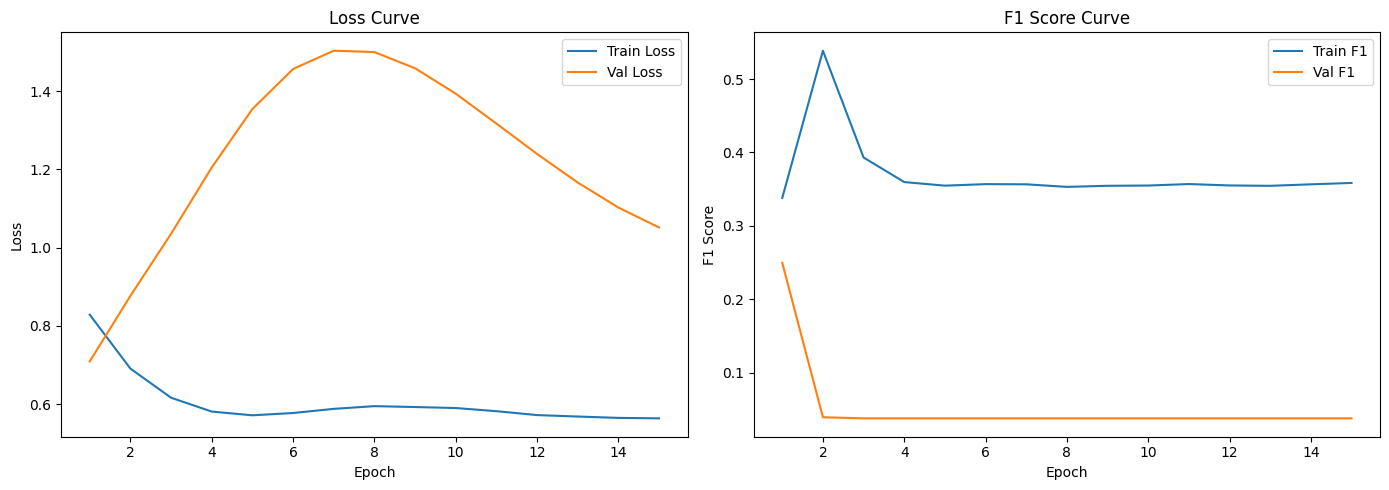

In [12]:
chosen = all_results[best_weight]
epochs = range(1, MAX_EPOCHS + 1)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, chosen["train_loss"], label="Train Loss")
plt.plot(epochs, chosen["val_loss"], label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Curve"); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, chosen["train_f1"], label="Train F1")
plt.plot(epochs, chosen["val_f1"], label="Val F1")
plt.xlabel("Epoch"); plt.ylabel("F1 Score"); plt.title("F1 Score Curve"); plt.legend()

plt.tight_layout(); plt.savefig("training_curves.png")
plt.show()
